Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
importing Jupyter notebook from DataCleaning.ipynb
['REAL' 'FAKE']
Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


2023-11-19 12:46:52.040586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]
2023-11-19 12:46:52.040811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100000]
	 [[{{node Placeholder/_0}}]]
2023-11-19 12:46:52.086685: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 100000 images belonging to 2 classes.
Found 100000 images belonging to 2 classes.


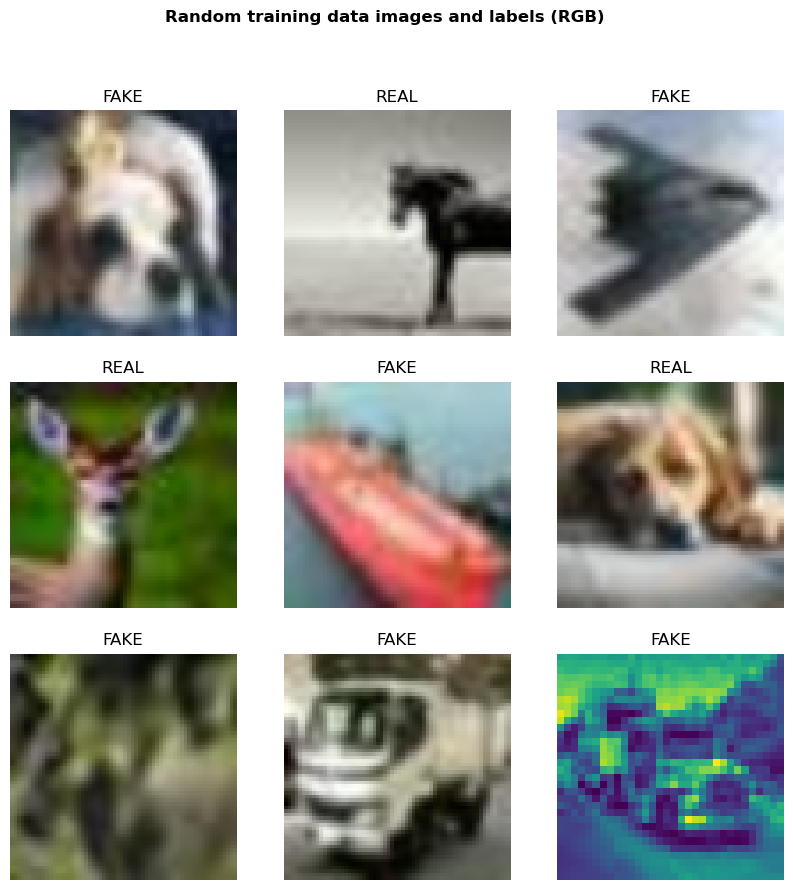

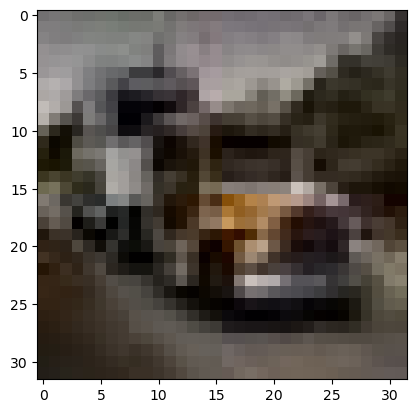

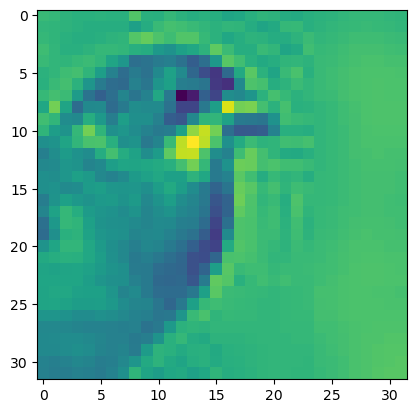

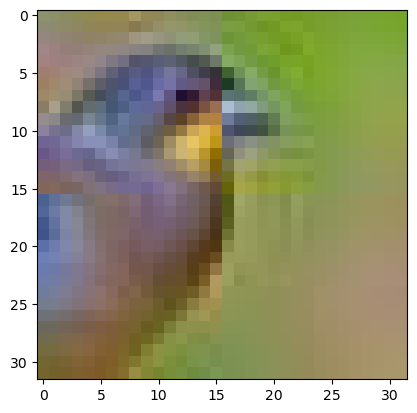

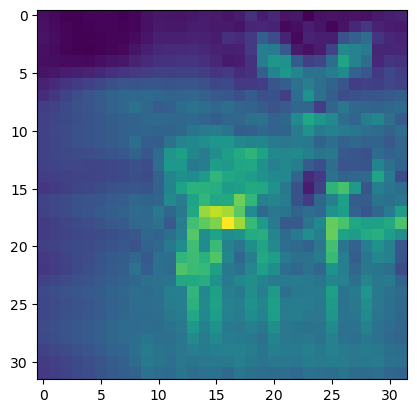

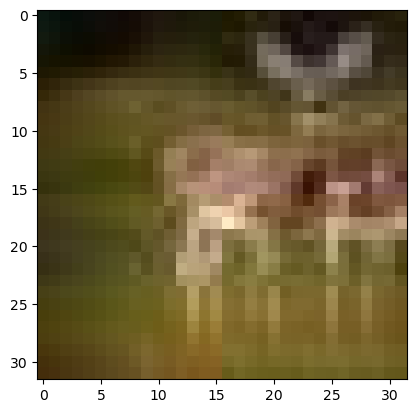

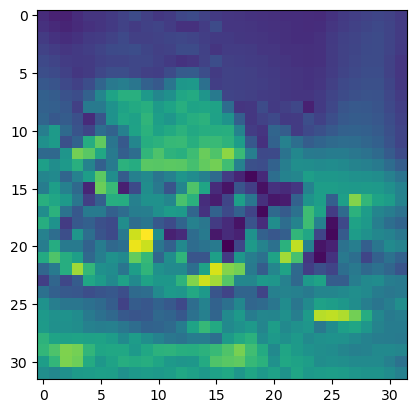

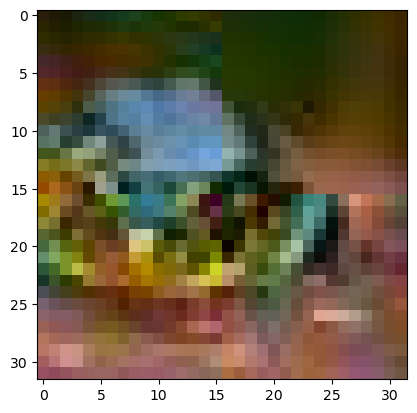

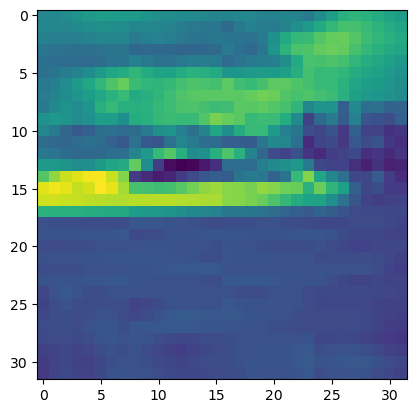

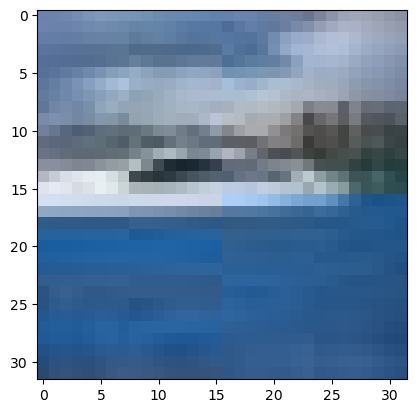

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.naive_bayes import GaussianNB


%pip install nbformat
%pip install import_ipynb

import import_ipynb
import DataCleaning


In [46]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.naive_bayes import GaussianNB

train_dir = '../archive/train'
batch_size = 32 

TRAIN_IMAGE_GENERATOR = ImageDataGenerator(rescale=1./255)

TRAIN_GENERATOR_GRAY = TRAIN_IMAGE_GENERATOR.flow_from_directory(
    train_dir,
    target_size = (32, 32),
    class_mode = 'categorical',
    color_mode = 'grayscale',
    shuffle = False
)

TRAIN_GENERATOR_RGB = TRAIN_IMAGE_GENERATOR.flow_from_directory(
    train_dir,
    target_size = (32, 32),
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False
)
#difference between this and data cleaning is 'categorical class mode'

# Load images and labels
num_samples_gray = len(TRAIN_GENERATOR_GRAY.filenames)
num_classes_gray = len(TRAIN_GENERATOR_GRAY.class_indices)

num_samples_rgb = len(TRAIN_GENERATOR_RGB.filenames)
num_classes_rgb = len(TRAIN_GENERATOR_RGB.class_indices)



X_gray = np.zeros((num_samples_gray, 32, 32, 3))
y_gray = np.zeros((num_samples_gray))

X_rgb = np.zeros((num_samples_rgb, 32, 32, 3))
y_rgb = np.zeros((num_samples_rgb))


for i in range(num_samples_gray // batch_size):
    batch_X, batch_y = TRAIN_GENERATOR_GRAY.next()
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    X_gray[start_idx:end_idx] = batch_X
    y_gray[start_idx:end_idx] = np.argmax(batch_y, axis=1)


for i in range(num_samples_rgb // batch_size):
    batch_X, batch_y = TRAIN_GENERATOR_RGB.next()
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    X_rgb[start_idx:end_idx] = batch_X
    y_rgb[start_idx:end_idx] = np.argmax(batch_y, axis=1)



# Reshape X to a 2D matrix for scikit-learn
X_reshaped_gray = X_gray.reshape(num_samples_gray, -1)
X_reshaped_rgb = X_rgb.reshape(num_samples_rgb, -1)

# Create a scikit-learn Naive Bayes classifier
nb_gray = GaussianNB()
nb_rgb = GaussianNB()

# Fit the Naive Bayes classifier with the flattened image data
y_pred_gray = nb_gray.fit(X_reshaped_gray, y_gray).predict(X_reshaped_gray)
y_pred_rgb = nb_rgb.fit(X_reshaped_rgb, y_rgb).predict(X_reshaped_rgb)

print(y_pred_gray)
print(y_pred_rgb)

print("Number of GRAY mislabeled points out of a total %d points : %d" % (X_reshaped_gray.shape[0], (y_gray != y_pred_gray).sum()))
print("Number of RGB mislabeled points out of a total %d points : %d" % (X_reshaped_rgb.shape[0], (y_rgb != y_pred_rgb).sum()))


Found 100000 images belonging to 2 classes.
Found 100000 images belonging to 2 classes.


0.60295
0.60328
[[34724 15276]
 [24429 25571]]
[[33019 16981]
 [22691 27309]]
0.345
0.33


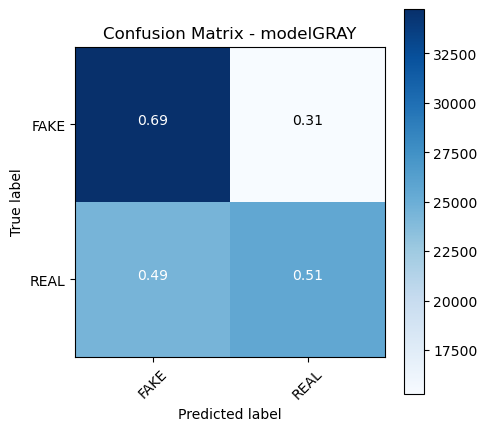

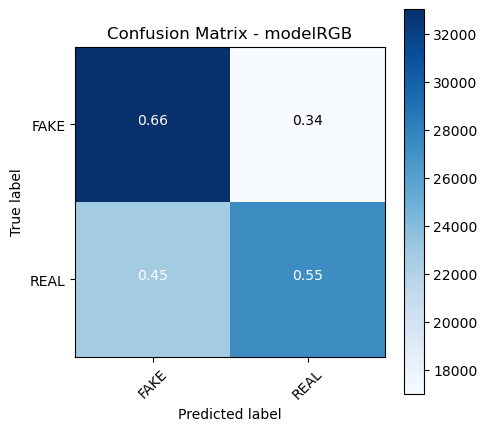

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools as it

acc_score_gray = accuracy_score(y_gray, y_pred_gray)
acc_score_rgb = accuracy_score(y_rgb, y_pred_rgb)


conf_mat_gray = confusion_matrix(
        y_gray, y_pred_gray)
conf_mat_rgb = confusion_matrix(
        y_rgb, y_pred_rgb)


print(acc_score_gray)
print(acc_score_rgb)
print(conf_mat_gray)
print(conf_mat_rgb)

def plot_confusion_matrix(cm, title, target_names, cmap=plt.cm.Blues):
    
    plt.figure(figsize=(5,5))

    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    # NORMALIZE:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0

    thresh = cm.max() / 2.
    print(thresh)
    for i, j in it.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh + .01 else "black")
    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

target_names_gray = []
target_names_RGB = []

for key in DataCleaning.TRAIN_GENERATOR_GRAY.class_indices:
    target_names_gray.append(key)

for key in DataCleaning.TRAIN_GENERATOR_RGB.class_indices:
    target_names_RGB.append(key)

plot_confusion_matrix(conf_mat_gray,title="Confusion Matrix - modelGRAY",target_names=target_names_gray)
plot_confusion_matrix(conf_mat_rgb,title="Confusion Matrix - modelRGB",target_names=target_names_RGB)